In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

In [2]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('stripe82_galaxies.csv')

X = df.drop(columns=['z']).values
y = df['z'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standarise the data
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# # Convert Array to Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [4]:
# Hyperparameters
input_dim = X_train.size(1)
hidden_dim = 32
num_mixture = 30
g_dim = 32
d_dim = 32
z_dim = 20

#### CGAN

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + 4, g_dim),
            nn.BatchNorm1d(g_dim),
            nn.ReLU(),
            nn.Linear(g_dim, g_dim),
            nn.BatchNorm1d(g_dim),
            nn.ReLU(),
            nn.Linear(g_dim, 1),
        )

    def forward(self, x, z):
        out = torch.cat([x, z], dim=1)
        return self.net(out)

#### MDN

In [6]:
class MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_mixture):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU(),
        )

        self.num_mixture = num_mixture  #  π, σ, μ for each mixture
        self.out= nn.Linear(hidden_dim, num_mixture * 3)

    def forward(self, x):
        x = self.hidden(x)
        output = self.out(x)

        # Splitting output into mean, std and mixing coeffs
        pi_logist, mu, log_sigma = torch.chunk(output, 3, dim=1)
        sigma = torch.exp(log_sigma)    # ensure positivity
        pi = torch.nn.functional.softmax(pi_logist, dim=1)

        return pi, mu, sigma

#### Load Models

In [7]:
model_CGAN = Generator()
model_CGAN.load_state_dict(torch.load("CGAN_model.pth", map_location=device))
model_CGAN.to(device)
model_CGAN.eval()

model_MDN = MDN(input_dim, hidden_dim, num_mixture)
model_MDN.load_state_dict(torch.load("MDN_model.pth", map_location=device))
model_MDN.to(device)
model_MDN.eval()

# inverse the tranform of y_test
y_test = scaler_y.inverse_transform(y_test.numpy())

####  Point-estimation quality metrics

In [8]:
def point_metrics(y_true, y_pred, n_bootstrap=1000, n_bins=20):
    bins = np.linspace(0, 0.8, n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    bias_med, sigma_med, outlier_med = [], [], []
    bias_ci, sigma_ci, outlier_ci = [], [], []

    for i in range(n_bins):
        mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
        yb = y_true[mask]
        yp = y_pred[mask]
        results = []
        for _ in range(n_bootstrap):
            idx = np.random.choice(len(yb), len(yb), replace=True)
            yb_sample, yp_sample = yb[idx], yp[idx]
            delta_z = (yp_sample - yb_sample) / (1 + yb_sample)
            bias = np.mean(np.abs(delta_z))
            sigma = 1.48 * np.median(np.abs(delta_z - np.median(delta_z)))
            outlier = np.mean(np.abs(delta_z) > 0.15)
            results.append((bias, sigma, outlier))
        results = np.array(results)

        bias_med.append(np.median(results[:, 0]))
        sigma_med.append(np.median(results[:, 1]))
        outlier_med.append(np.median(results[:, 2]))

        bias_ci.append((np.percentile(results[:, 0], 2.5), np.percentile(results[:, 0], 97.5)))
        sigma_ci.append((np.percentile(results[:, 1], 2.5), np.percentile(results[:, 1], 97.5)))
        outlier_ci.append((np.percentile(results[:, 2], 2.5), np.percentile(results[:, 2], 97.5)))

    return {
        "bin_centers": bin_centers,
        "bias": np.array(bias_med),
        "bias_ci": np.array(bias_ci),
        "sigma": np.array(sigma_med),
        "sigma_ci": np.array(sigma_ci),
        "outlier": np.array(outlier_med),
        "outlier_ci": np.array(outlier_ci),
    }

#### Probability-density-function quality metrics

In [9]:
def pdf_metrics(z_spec, pdfs, z_grid, point_estimates):
    xi = 0.06
    dz = z_grid[1] - z_grid[0]
    credibility = np.linspace(0, 1, 20)

    cdfs = np.cumsum(pdfs, axis=1) * dz
    cdfs /= cdfs[:, -1][:, None]  

    # PIT:
    pit = np.array([np.interp(z, z_grid, cdf) for z, cdf in zip(z_spec, cdfs)])

    # Odds: 
    odds = []
    for p, zp in zip(pdfs, point_estimates):
        mask = (z_grid >= zp - xi) & (z_grid <= zp + xi)
        odds.append(np.sum(p[mask]) * dz)
    odds = np.array(odds)

    # Coverage 
    coverage = []
    for alpha in credibility:
        lower = (1 - alpha) / 2
        upper = 1 - lower
        count = 0
        for z, cdf in zip(z_spec, cdfs):
            z_lower = np.interp(lower, cdf, z_grid)
            z_upper = np.interp(upper, cdf, z_grid)
            if z_lower <= z <= z_upper:
                count += 1
        coverage.append(count / len(z_spec))
    coverage = np.array(coverage)


    return {
        'pit': pit,
        'odds': odds,
        'coverage': coverage,
        'credibility': credibility
    }

#### Model Evaluation

In [10]:
z_grid = np.linspace(0, 0.8, 200)
dz = z_grid[1] - z_grid[0]

with torch.no_grad():
    # CGAN
    z = torch.randn(X_test.size(0), z_dim, device=device)
    y_pred_cgan = model_CGAN(X_test, z).cpu().numpy()
    y_pred_cgan = scaler_y.inverse_transform(y_pred_cgan)
    results_cgan_point = point_metrics(y_test, y_pred_cgan)

    pdfs_cgan = []
    for x in X_test:
        x_rep = x.repeat(X_test.size(0), 1).to(device)
        z = torch.randn(X_test.size(0), z_dim, device=device)
        preds = model_CGAN(x_rep, z).cpu().numpy()
        preds = scaler_y.inverse_transform(preds)
        hist, _ = np.histogram(preds, bins = z_grid, density=True)
        hist = np.append(hist, hist[-1])
        pdf = hist / np.sum(hist * dz)
        pdfs_cgan.append(pdf)
    pdfs_cgan = np.array(pdfs_cgan)
    

    # MDN
    pi, mu, sigma = model_MDN(X_test)
    y_pred_mdn = (pi * mu).sum(dim=1, keepdim=True)
    y_pred_mdn = scaler_y.inverse_transform(y_pred_mdn.numpy())
    results_mdn_point = point_metrics(y_test, y_pred_mdn)

    pdfs_mdn = []
    pi = pi.squeeze().cpu().numpy()
    mu = scaler_y.inverse_transform(mu.cpu().numpy())
    sigma = sigma.cpu().numpy() * scaler_y.scale_[0]

    for i in range(len(X_test)):
        p = np.zeros_like(z_grid)
        for k in range(pi.shape[1]):
            p += pi[i, k] * norm.pdf(z_grid, mu[i, k], sigma[i, k])
        p /= np.trapz(p, z_grid)
        pdfs_mdn.append(p)
    pdfs_mdn = np.array(pdfs_mdn)


results_cgan_pdf = pdf_metrics(y_test, pdfs_cgan, z_grid, y_pred_cgan)
results_mdn_pdf = pdf_metrics(y_test, pdfs_mdn, z_grid, y_pred_mdn)

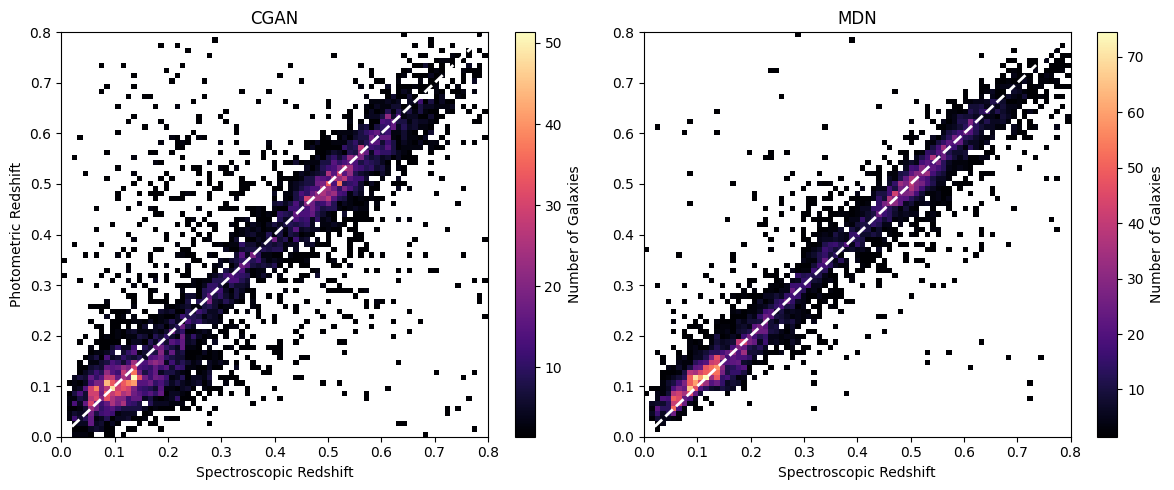

In [11]:
bins = np.linspace(0, 0.8, 80)

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
h, x, y = np.histogram2d(y_test.flatten(), y_pred_cgan.flatten(), bins=bins, density=True)
h = np.ma.masked_equal(h, 0)

plt.pcolormesh(x, y, h.T, cmap="magma")
plt.plot([0, 0.8], [0, 0.8], 'w--', lw=2)
plt.colorbar(label='Number of Galaxies')
plt.xlim(0, 0.8)
plt.ylim(0, 0.8)
plt.title("CGAN")
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Photometric Redshift")

plt.subplot(1, 2, 2)
h, x, y = np.histogram2d(y_test.flatten(), y_pred_mdn.flatten(), bins=bins, density=True)
h = np.ma.masked_equal(h, 0)

plt.pcolormesh(x, y, h.T, cmap="magma")
plt.plot([0, 0.8], [0, 0.8], 'w--', lw=2)
plt.colorbar(label='Number of Galaxies')
plt.xlim(0, 0.8)
plt.ylim(0, 0.8)
plt.title("MDN")
plt.xlabel("Spectroscopic Redshift")

plt.tight_layout()
plt.savefig('z_photo_vs_z_spec.png', dpi=300, bbox_inches='tight')
plt.show()


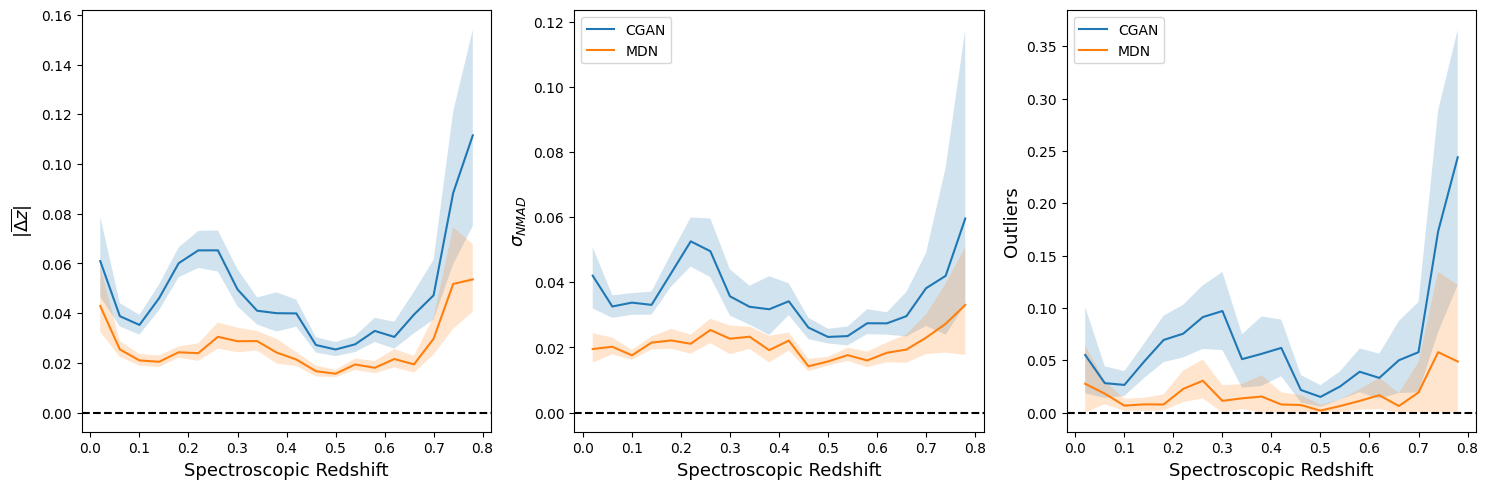

In [12]:
bin_center = results_cgan_point['bin_centers']

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.plot(bin_center, results_cgan_point['bias'], label = 'CGAN')
plt.plot(bin_center, results_mdn_point['bias'], label = 'MDN')
plt.fill_between(bin_center, results_cgan_point['bias_ci'][:,0], results_cgan_point['bias_ci'][:,1], alpha=0.2)
plt.fill_between(bin_center, results_mdn_point['bias_ci'][:,0], results_mdn_point['bias_ci'][:,1], alpha=0.2)
plt.axhline(y=0, color='k', linestyle='--')
# plt.title("Mean Absolute Bias", fontsize=13)
plt.xlabel('Spectroscopic Redshift', fontsize=13)
plt.ylabel(r'$|\overline{\Delta z}|$', fontsize=13) 

plt.subplot(1,3,2)
plt.plot(bin_center, results_cgan_point['sigma'], label = 'CGAN')
plt.plot(bin_center, results_mdn_point['sigma'], label = 'MDN')
plt.fill_between(bin_center, results_cgan_point['sigma_ci'][:,0], results_cgan_point['sigma_ci'][:,1], alpha=0.2)
plt.fill_between(bin_center, results_mdn_point['sigma_ci'][:,0], results_mdn_point['sigma_ci'][:,1], alpha=0.2)
plt.axhline(y=0, color='k', linestyle='--')
# plt.title("Normalized Median Absolute Deviation ", fontsize=13)
plt.xlabel('Spectroscopic Redshift', fontsize=13)
plt.ylabel(r'$\sigma_{NMAD}$', fontsize=13)  
plt.legend()

plt.subplot(1,3,3)
plt.plot(bin_center, results_cgan_point['outlier'], label = 'CGAN')
plt.plot(bin_center, results_mdn_point['outlier'], label = 'MDN')
plt.fill_between(bin_center, results_cgan_point['outlier_ci'][:,0], results_cgan_point['outlier_ci'][:,1], alpha=0.2)
plt.fill_between(bin_center, results_mdn_point['outlier_ci'][:,0], results_mdn_point['outlier_ci'][:,1], alpha=0.2)
plt.axhline(y=0, color='k', linestyle='--')
# plt.title("Outlier Ratio", fontsize=13)
plt.xlabel('Spectroscopic Redshift', fontsize=13)
plt.ylabel('Outliers', fontsize=13)
plt.legend()
plt.tight_layout()
plt.savefig('point matrics.png', dpi=300, bbox_inches='tight')
plt.show()

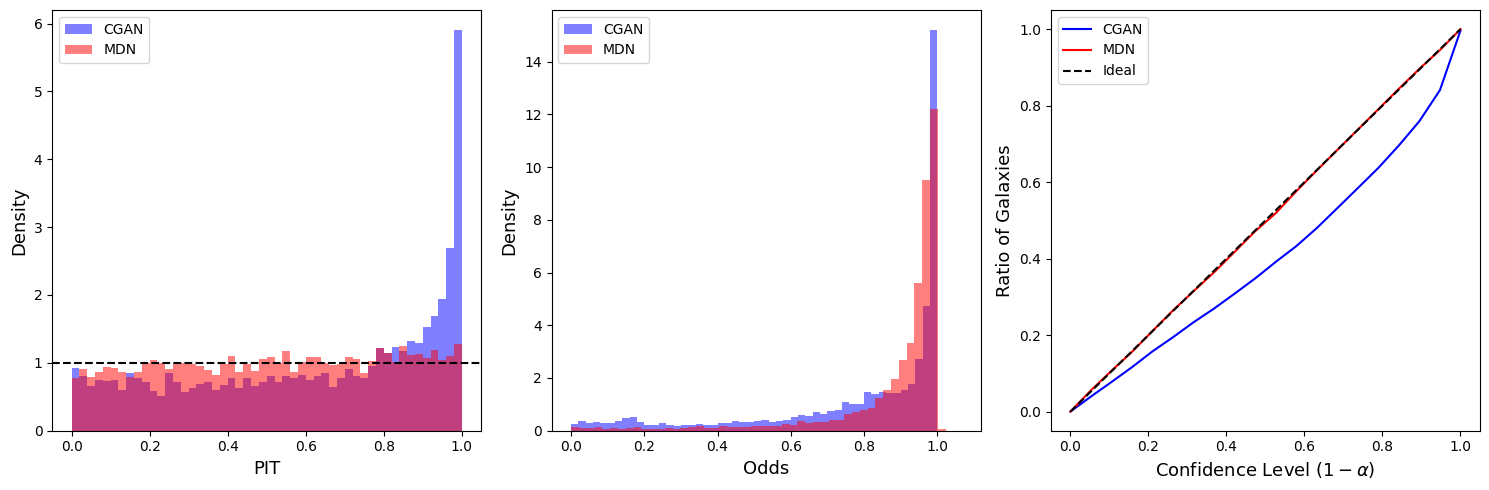

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# PIT
ax1.hist(results_cgan_pdf['pit'], bins=50, density=True, alpha=0.5, color='blue', label='CGAN')
ax1.hist(results_mdn_pdf['pit'], bins=50, density=True, alpha=0.5, color='red', label='MDN')
ax1.axhline(1, color='black', linestyle='--')
ax1.set_xlabel('PIT', fontsize=13)
ax1.set_ylabel('Density', fontsize=13)
# ax1.set_title('PIT')
ax1.legend()

# Odds
ax2.hist(results_cgan_pdf['odds'], bins=50, density=True, alpha=0.5, color='blue', label='CGAN')
ax2.hist(results_mdn_pdf['odds'], bins=50, density=True, alpha=0.5, color='red', label='MDN')
ax2.set_xlabel('Odds', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Odds', fontsize=13)
ax2.legend()

# Coverage
ax3.plot(results_cgan_pdf['credibility'], results_cgan_pdf['coverage'], 'b-', label='CGAN')
ax3.plot(results_mdn_pdf['credibility'], results_mdn_pdf['coverage'], 'r-', label='MDN')
ax3.plot([0, 1], [0, 1], 'k--', label='Ideal')
ax3.set_xlabel('Confidence Level ($1 - \\alpha$)', fontsize=13)
ax3.set_ylabel('Ratio of Galaxies', fontsize=13)
# ax3.set_title('Coverage Diagram', fontsize=13)
ax3.legend()

plt.tight_layout()
plt.savefig('pdf metrices.png', dpi=300, bbox_inches='tight')
plt.show()

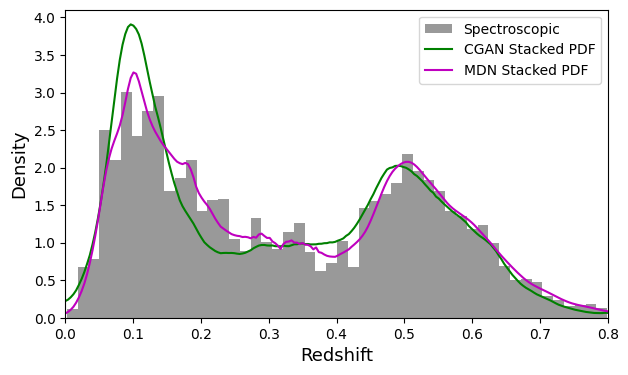

In [14]:
plt.figure(figsize=(7, 4))
plt.hist(y_test, bins=50, density=True, color='black', alpha=0.4, label='Spectroscopic')
plt.plot(z_grid, np.mean(pdfs_cgan, axis=0), 'g-', label='CGAN Stacked PDF')
plt.plot(z_grid, np.mean(pdfs_mdn, axis=0), 'm-', label='MDN Stacked PDF')
plt.xlabel('Redshift', fontsize=13)
plt.ylabel('Density', fontsize=13)
# plt.title('Spectroscopic vs Stacked PDF', fontsize=13)
plt.legend()
plt.xlim(0, 0.8)
plt.savefig('stacked pdf.png', dpi=300, bbox_inches='tight')
plt.show()